## License Information
---

This file is distributed as part of _swprocess_, a Python package for surface wave processing.

    Copyright (C) 2020 Joseph P. Vantassel (joseph.p.vantassel@gmail.com)

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https: //www.gnu.org/licenses/>.
    
## About _swprocess_ and this notebook
---

_swprocess_ is a Python package for surface wave processing. _swprocess_ was developed by
Joseph P. Vantassel under the supervision of Professor Brady R. Cox at The University of
Texas at Austin.

If you use _swprocess_ in your research or consulting, we ask you please cite the following:

> Vantassel, J. P. (2021). jpvantassel/swprocess: latest (Concept). Zenodo.
> [https://doi.org/10.5281/zenodo.4584128](https://doi.org/10.5281/zenodo.4584128)

> Vantassel, J. P. & Cox, B. R. (2022). "SWprocess: a workflow for developing robust
> estimates of surface wave dispersion uncertainty". Journal of Seismology.
> [https://doi.org/10.1007/s10950-021-10035-y](https://doi.org/10.1007/s10950-021-10035-y)

_Note: For software, version specific citations should be preferred to
general concept citations, such as that listed above. To generate a version
specific citation for _swprocess_, please use the citation tool on the _swprocess_
[archive](https://doi.org/10.5281/zenodo.4584128)._

The data presented in this notebook is from the WGHS site in Wellington, NZ. The data
has been archived and made publically on the DesignSafe-CI by Cox and Vantassel (2018),
full citation and link to the data are provided below.

> Cox, B. R. & Vantssel, J. P. (2018). Dynamic Characterization of Wellington, New Zealand
> [Dataset]. DesignSafe-CI [publisher]. https://doi.org/10.17603/DS24M6J

## Getting Started
---
1. Install _swprocess_ and its dependencies, with `pip install swprocess`. If you are not familiar with `pip`, a useful tutorial can be found [here](https://jpvantassel.github.io/python3-course/#/intro/pip). __(~3 minutes)__ 
2. Execute the notebook to process the acitve-source data (i.e., SEG2 format .dat files) into estimates of the site's surface wave dispersion and write the results into the `.json` format. Note the `.json` file(s) created by this notebook will be used later in the example notebook (`stats.ipynb`). __(~3 minutes)__
3. Repeat the process exploring the available pre-processing, processing, and visualization settings. __(~20 minutes)__
4. Use the notebook to process MASW data for your next project.

Happy Processing!

In [1]:
import json
import time

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np

import swprocess

## Input
---

### Files

In [2]:
# Path (relative or full) to a folder containing the data files. Data files must be in either the SEG2 and/or SU data format.
path_to_folder = "./SU_Files_MASW"
source = "hammer"
nshots = 5

# Files grouped by source offset. Each set may contain the location a single or multiple files.
# By default the notebook assumes that multiple source offsets have been used (6 in this examples, set0 to set5)
# with multiple shots per source offset (5 in this example). The files of a set will be stacked according
# to the selected MASW workflow (selected next).
set0 = [f"{path_to_folder}/{source}_p_geo_-5m_{x}.su" for x in range(nshots)]
set1 = [f"{path_to_folder}/{source}_p_geo_-10m_{x}.su" for x in range(nshots)]
set2 = [f"{path_to_folder}/{source}_p_geo_-20m_{x}.su" for x in range(nshots)]
set3 = [f"{path_to_folder}/{source}_p_geo_-40m_{x}.su" for x in range(nshots)]
fnames_set = [set0, set1, set2, set3]

print("Summary:")
for set_number, fnames in enumerate(fnames_set):
    print(f"  set{set_number} includes {len(fnames)} files from {fnames[0]} to {fnames[-1]}")

Summary:
  set0 includes 5 files from ./SU_Files_MASW/hammer_p_geo_-5m_0.su to ./SU_Files_MASW/hammer_p_geo_-5m_4.su
  set1 includes 5 files from ./SU_Files_MASW/hammer_p_geo_-10m_0.su to ./SU_Files_MASW/hammer_p_geo_-10m_4.su
  set2 includes 5 files from ./SU_Files_MASW/hammer_p_geo_-20m_0.su to ./SU_Files_MASW/hammer_p_geo_-20m_4.su
  set3 includes 5 files from ./SU_Files_MASW/hammer_p_geo_-40m_0.su to ./SU_Files_MASW/hammer_p_geo_-40m_4.su


### Names

In [3]:
# Name for each fnames_set, if None, sets will be named according to the source position.
names = [f"{source}_{offset}" for offset in ["-5m", "-10m", "-20m", "-40m"]]

### Workflow

In [4]:
# Masw workflow {"time-domain", "frequency-domain", "single"}, time-domain is recommended
workflow = "time-domain"

### Pre-processing

In [5]:
# Trim record between the specified begin and end times (time in seconds). Trimming is recommended, however
# it must be done carefully to avoid accidentally trimming signal, particularly for far offsets.
trim, trim_begin, trim_end = True, 0, 1

# Mute portions of the time-domain record to isolate surface wave energy. No muting is recommended.
# Mute method {"interactive"} and window_kwargs (see documenation for details).
mute, method, window_kwargs = False, "interactive", {}

# Zero pad the time-domain record to achieve a desired frequency step. Padding with df=0.5 is recommended.
pad, df = True, 0.5

### Processing

In [6]:
# Wavefield transform {"fk", "slantstack", "phaseshift", "fdbf"}, "fdbf" is recommended.
transform = "fdbf"

# Minimum and maximum frequencies of interest (frequency in Hertz).
fmin, fmax = 3, 100

# Selection of trial velocities (velocity in m/s) with minimum, maximum, number of steps, and space {"linear", "log"}.  
vmin, vmax, nvel, vspace = 100, 500, 400, "linear"

# Weighting for "fdbf" {"sqrt", "invamp", "none"} (ignored for all other wavefield transforms). "sqrt" is recommended. 
fdbf_weighting = "sqrt"

# Steering vector for "fdbf" {"cylindrical", "plane"} (ignored for all other wavefield transforms). "cylindrical" is recommended.
fdbf_steering = "cylindrical"

### Signal-to-Noise

In [7]:
# Compute the records signal-to-noise ratio. 
snr = True

# Define noise and signal windows being and end times (time in seconds). Negative time refers to pre-trigger record.
noise_begin, noise_end =  -0.5, 0.
signal_begin, signal_end = 0., 0.5

# Zero pad the noise and signal records to achieve a specified frequency step. Padding with df=1 is recommended.
pad_snr, df_snr = True, 1

## Analysis
---


In [8]:
# Perform the selcted MASW workflow. No changes to this cell are required, however you may
# wish to change the variable `settings_fname` to a more specific name for later reference.
# This cell may take several seconds to run.
%matplotlib qt5
settings = swprocess.Masw.create_settings_dict(workflow=workflow,
                                               trim=trim, trim_begin=trim_begin, trim_end=trim_end,
                                               mute=mute, method=method, window_kwargs=window_kwargs,
                                               transform=transform, fmin=fmin, fmax=fmax, pad=pad, df=df,
                                               vmin=vmin, vmax=vmax, nvel=nvel, vspace=vspace,
                                               weighting=fdbf_weighting, steering=fdbf_steering,
                                               snr=snr, noise_begin=noise_begin, noise_end=noise_end,
                                               signal_begin=signal_begin, signal_end=signal_end,
                                               pad_snr = pad_snr, df_snr=df_snr)

start = time.perf_counter()
wavefieldtransforms = []
for fnames in fnames_set: 
    wavefieldtransforms.append(swprocess.Masw.run(fnames=fnames, settings=settings))
end = time.perf_counter()
print(f"Elapsed Time (s): {round(end-start,2)}")

C:\Users\vanta\Documents\trainings\2024_07_us_vs\venv\lib\site-packages\swprocess\sensor1c.py:199: UserWarning: Resetting nstacks from zero to one.
  warnings.warn(msg)
C:\Users\vanta\Documents\trainings\2024_07_us_vs\venv\lib\site-packages\swprocess\sensor1c.py:199: UserWarning: Resetting nstacks from zero to one.
  warnings.warn(msg)
C:\Users\vanta\Documents\trainings\2024_07_us_vs\venv\lib\site-packages\swprocess\sensor1c.py:199: UserWarning: Resetting nstacks from zero to one.
  warnings.warn(msg)
C:\Users\vanta\Documents\trainings\2024_07_us_vs\venv\lib\site-packages\swprocess\sensor1c.py:199: UserWarning: Resetting nstacks from zero to one.
  warnings.warn(msg)
C:\Users\vanta\Documents\trainings\2024_07_us_vs\venv\lib\site-packages\swprocess\sensor1c.py:199: UserWarning: Resetting nstacks from zero to one.
  warnings.warn(msg)
C:\Users\vanta\Documents\trainings\2024_07_us_vs\venv\lib\site-packages\swprocess\sensor1c.py:199: UserWarning: Resetting nstacks from zero to one.
  warni

Elapsed Time (s): 8.49


## Post-Analysis Settings
---

### Dispersion Image

In [9]:
# Image normalization {"none", "absolute-maximum" "frequency-maximum"} -> "frequency-maximum" is recommended.
wavefield_normalization = "frequency-maximum"

# Display the wavelength resolution limit.
display_lambda_res = True

# Display Yoon and Rix (2009) near-field criteria
display_nearfield = False
number_of_array_center_distances = 1

## Signal-to-Noise Ratio (SNR)

In [10]:
# SNR threshold, frequencies with SNR below this value should be used cautiously.
# Wood and Cox (2012) recommended a minimum threshold of 10 dB (or SNR of ~3.2).
minimum_snr = 3.2

## Plot Results
---

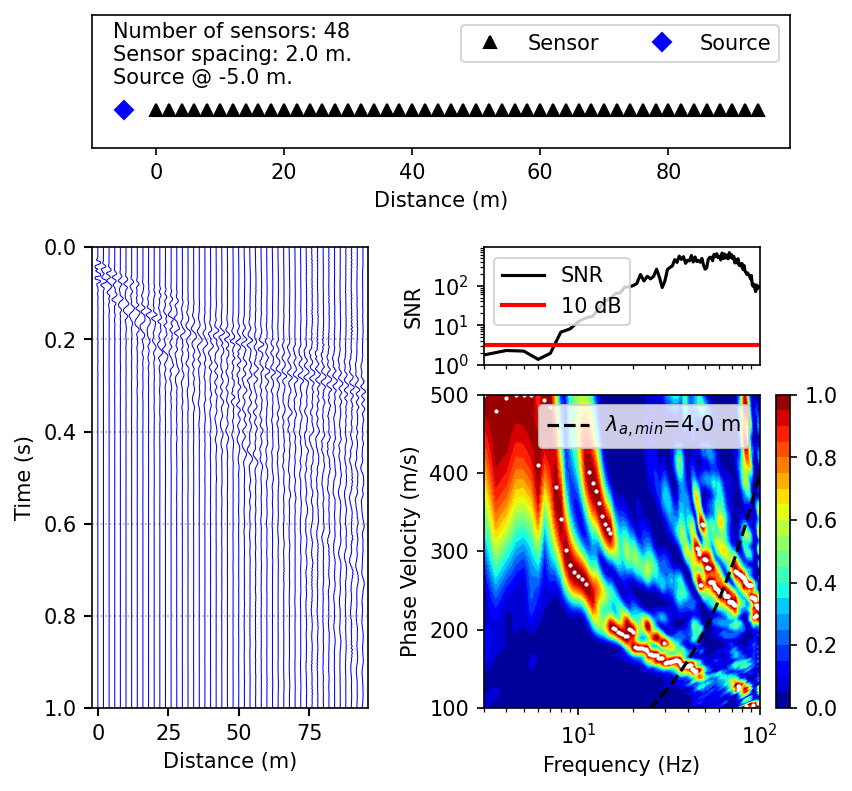

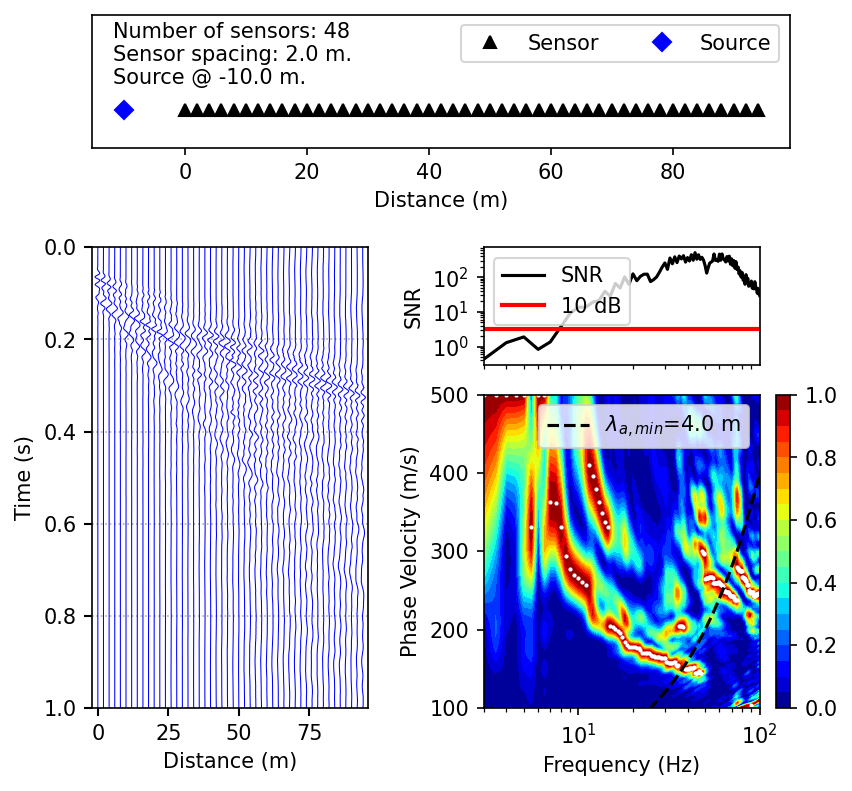

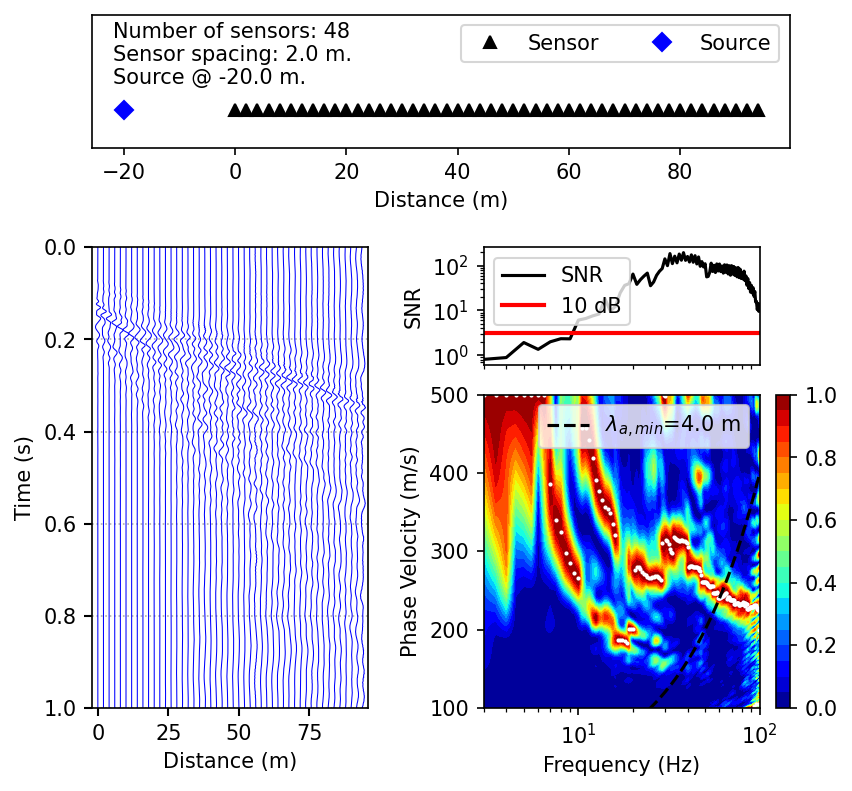

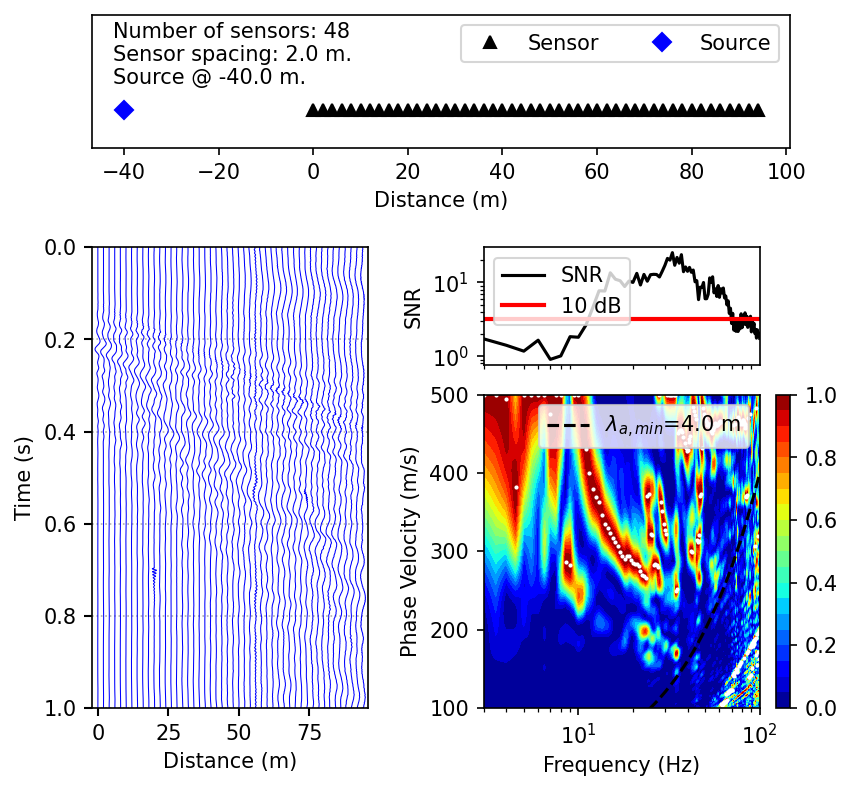

In [11]:
%matplotlib inline
figures = []
for wavefieldtransform in wavefieldtransforms:
    fig = plt.figure(figsize=(6,6), dpi=150)

    gs = GridSpec(nrows=4, ncols=4, height_ratios=(1.7, 0.5, 1.5, 4), width_ratios=(1, 0.3, 1, 0.05), hspace=0.2, wspace=0.1)
    ax0 = fig.add_subplot(gs[0, :])
    ax1 = fig.add_subplot(gs[2:4, 0])
    ax2 = fig.add_subplot(gs[2, 2])
    ax3 = fig.add_subplot(gs[3, 2])
    ax4 = fig.add_subplot(gs[3, 3])

    # Array
    wavefieldtransform.array.plot(ax=ax0)
    ax0.set_yticks([])
    ax0.legend(ncol=2)
    
    # Timeseries
    wavefieldtransform.array.waterfall(ax=ax1, amplitude_detrend=False, amplitude_normalization="each")
    if trim:
        ax1.set_ylim((trim_end, trim_begin))

    # Signal-to-Noise Ratio
    wavefieldtransform.plot_snr(ax=ax2, plot_kwargs=dict(color="black", label="SNR"))
    xlim = ax2.get_xlim()
    ax2.plot(xlim, [minimum_snr]*2, lw=2, color="red", label="10 dB")
    ax2.set_xlim(xlim)
    ax2.set_xticklabels([])
    ax2.set_xlabel("")
    ax2.set_ylabel("SNR")
    ax2.set_yscale("log")
    ax2.legend(loc="upper left")
    
    # Dispersion Image
    nearfield = number_of_array_center_distances if display_nearfield else None
    wavefieldtransform.plot(fig=fig, ax=ax3, cax=ax4, normalization=wavefield_normalization, nearfield=nearfield)
    xlim = ax3.get_xlim()
    ylim = ax3.get_ylim()
    if display_lambda_res:
        kres_format = dict(linewidth=1.5, color="#000000", linestyle="--")
        kres = wavefieldtransform.array.kres
        kvelocity = 2*np.pi*wavefieldtransform.frequencies / kres
        ax3.plot(wavefieldtransform.frequencies, kvelocity, label=r"$\lambda_{a,min}$" + f"={np.round(2*np.pi/kres,2)} m", **kres_format)
        ax3.legend(loc="upper right")
    ax3.set_xlim(xlim)
    ax2.set_xlim(xlim)
    ax3.set_ylim(ylim)
    ax2.set_xscale("log")
    ax2.set_xticks([])
    ax3.set_xscale("log")
    
    figures.append(fig)
    plt.show()
    print("\n\n\n")

## Plot Setting
---

In [12]:
# Domains in which to plot the experimental dispersion data.
domains = [
    ["frequency", "velocity"],
    ["wavelength", "velocity"],
]

## Plot Summary
---

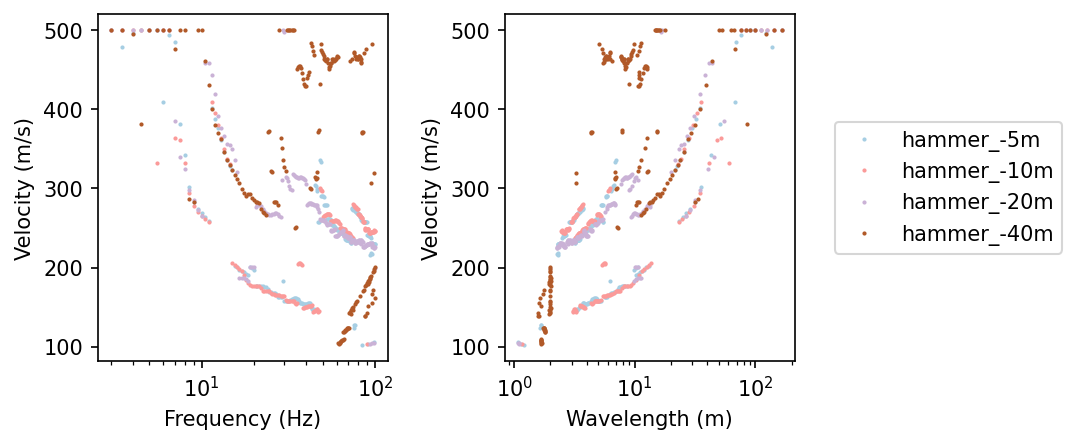

In [13]:
%matplotlib inline
xtype = [x for x, _ in domains]
ytype = [y for _, y in domains]
labels = names if names is not None else [f"{x.array.source.x:.1f} m" for x in wavefieldtransforms]
cmap = plt.get_cmap(name="Paired", lut=len(labels))
colors = [mpl.colors.to_hex(cmap.colors[x]) for x in range(len(labels))] 

if len(fnames_set) != len(colors) or len(fnames_set) != len(labels):
    raise IndexError(f"fnames_set, colors, and labels must be the same length.")

fig, axs = plt.subplots(ncols=len(xtype), figsize=(6,3), dpi=150, gridspec_kw=dict(wspace=0.4))

for wavefieldtransform, color, label in zip(wavefieldtransforms, colors, labels):
    peak = swprocess.peaks.Peaks(wavefieldtransform.frequencies,
                                 wavefieldtransform.find_peak_power(by="frequency-maximum"),
                                 identifier=label)
    peaksuite = swprocess.PeaksSuite.from_peaks([peak])
    peaksuite.plot(xtype=xtype, ax=axs, ytype=ytype, plot_kwargs=dict(color=color, label=label))

axs[-1].legend(bbox_to_anchor = (1.1, 0.5), loc="center left")
plt.show()

## Save Peaks to File
---

In [14]:
prefix = "hb_hammer"
one_file_per_fname_set = False

names = names if names is not None else [f"{x.array.source.x}" for x in wavefieldtransforms]
if len(names) != len(wavefieldtransforms):
    raise ValueError(f"len(fnames_set)={len(fnames_set)} must equal len(names)={len(names)}.")

append = False
for name, wavefieldtransform in zip(names, wavefieldtransforms):
    peak = swprocess.peaks.Peaks(wavefieldtransform.frequencies,
                                 wavefieldtransform.find_peak_power(by="frequency-maximum"),
                                 identifier=name)
    fname = f"{prefix}_{name}m.json" if one_file_per_fname_set else f"{prefix}_masw.json"
    peak.to_json(fname=fname, append=append)
    append = False if one_file_per_fname_set else True

## Save Images
---

In [15]:
# for name, wavefieldtransform, figure in zip(names, wavefieldtransforms, figures):
#     figure.savefig(f"{prefix}_{name}m.png", dpi=300, bbox_inches="tight")